In [1]:
import os
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/city')

In [4]:
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.4 MB/s eta 0:00:00


In [5]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import os
import cv2
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.nn import Module
from unet_orig import UNet
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm
from earlyStopping import EarlyStopping
from torchmetrics import JaccardIndex


In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [8]:
INIT_LR = 0.1
NUM_EPOCHS = 500
BATCH_SIZE = 5
N_CLASS = 20

BASE_OUTPUT ="/content/drive/My Drive/Colab Notebooks/city/output"
CHECKPOINTS_PATH=BASE_OUTPUT+"/checkpoints/"
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_cityscapes_baseline.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Train_Test_Plot_baseline.png"])


In [8]:
mapping_20 = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 2,
        9: 0,
        10: 0,
        11: 3,
        12: 4,
        13: 5,
        14: 0,
        15: 0,
        16: 0,
        17: 6,
        18: 0,
        19: 7,
        20: 8,
        21: 9,
        22: 10,
        23: 11,
        24: 12,
        25: 13,
        26: 14,
        27: 15,
        28: 16,
        29: 0,
        30: 0,
        31: 17,
        32: 18,
        33: 19,
        -1: 0
    }

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask


In [9]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image),t(target)

        image, target = image/255,encode_labels(target)

        return image, target


transform = Compose([
    transforms.PILToTensor(),
    transforms.Resize((512,1024),antialias=False)

])


train_dataset = torchvision.datasets.Cityscapes('/content/cityscape/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)

# use validation as test set
test_dataset = torchvision.datasets.Cityscapes('/content/cityscape/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
#test_dataset = torchvision.datasets.Cityscapes('/Users/beyzaecemerce/GitHub/city/cityscapes', split='test', mode='fine',
                     #target_type='semantic',transforms=transform)


train_set, val_set = torch.utils.data.random_split(train_dataset,  [2525, 450]) # 85% and 15%


trainLoader = torch.utils.data.DataLoader(train_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

valLoader = torch.utils.data.DataLoader(val_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

testLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [ ]:
TEST_PATHS = "/content/drive/MyDrive/Colab Notebooks/city/test/"
from PIL import Image
import torchvision.transforms.functional as TF
# Create the output folder if it doesn't exist
if not os.path.exists(TEST_PATHS):
    os.makedirs(TEST_PATHS)

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    image = TF.to_pil_image(image)
    label = label.squeeze(0)

    label = TF.to_pil_image(label)
    image_path = os.path.join(TEST_PATHS, f"image_{i}.png")
    image.save(image_path)
    label_path = os.path.join(TEST_PATHS, f"label_{i}.png")
    label.save(label_path)
    # Save processed images to the local folder

print("Images saved to", TEST_PATHS)

In [11]:
model=UNet(N_CLASS).to(DEVICE)

learning_rate=1e-3
weight_decay = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lossFunc=torch.nn.CrossEntropyLoss()

early_stopping=EarlyStopping(patience=5, delta=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, threshold=0.01, threshold_mode='abs', verbose=True)


In [12]:
def iou(pred, target,N_CLASS):
    ious = []
    for cls in range(N_CLASS):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [13]:
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(val_set) // BATCH_SIZE
loss_list = {"train_loss": [], "val_loss": []}

startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
  ############### TRAIN ###############
  model.train()
  totalTrainLoss = 0
  for (i, (x, y)) in enumerate(trainLoader):
    if None in (x,y):
        continue
    (x, y) = (x.to(DEVICE), torch.squeeze(y.to(DEVICE)).long())
    opt.zero_grad()
    pred = model(x)
    loss = lossFunc(pred, y)
    totalTrainLoss += loss.item()
    loss.backward()
    opt.step()

  ############### EVALUATION ###############
  model.eval()
  totalValidLoss = 0
  total_ious = []
  pixel_accs = []
  jaccard_index=[]
  with torch.no_grad():
    for (x, y) in valLoader:
      (x, y) = (x.to(DEVICE), torch.squeeze(y.to(DEVICE)).long())
      pred = model(x)
      loss=lossFunc(pred, y)
      totalValidLoss += loss.item()
      pred=torch.argmax(pred,dim=1)
      pred=pred.to(DEVICE)

      for p, t in zip(pred, y):
          total_ious.append(iou(p, t, N_CLASS))
          pixel_accs.append(pixel_acc(p, t))

  # Calculate metrics
  ious = torch.nanmean(torch.Tensor(total_ious))
  pixel_accs_mean = torch.nanmean(torch.Tensor(pixel_accs))
  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("meanIoU: {}, pixel_accs_mean: {}".format(ious, pixel_accs_mean))


  avgTrainLoss = totalTrainLoss / trainSteps
  avgValidLoss = totalValidLoss / testSteps
  loss_list["train_loss"].append(avgTrainLoss)
  loss_list["val_loss"].append(avgValidLoss)
  scheduler.step(avgValidLoss)
  print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValidLoss))


  if e+1%20==0:
    checkpoint = {
          'epoch': e,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': opt.state_dict()
      }
    torch.save(checkpoint, CHECKPOINTS_PATH+'checkpoint_epoch{}.pth'.format(e+1))


  early_stopping(avgValidLoss)
  if early_stopping.early_stop:
      print("Early stopping")
      break

torch.save(model.state_dict(), MODEL_PATH)

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  0%|          | 1/500 [07:34<62:57:55, 454.26s/it]

[INFO] EPOCH: 1/500
meanIoU: 0.19030864536762238, pixel_accs_mean: 0.676611602306366
Train loss: 1.350074, Validation loss: 1.0686


  0%|          | 2/500 [15:04<62:29:40, 451.77s/it]

[INFO] EPOCH: 2/500
meanIoU: 0.23369210958480835, pixel_accs_mean: 0.7304241061210632
Train loss: 0.819408, Validation loss: 0.8944


  1%|          | 3/500 [22:33<62:13:32, 450.73s/it]

[INFO] EPOCH: 3/500
meanIoU: 0.2710971236228943, pixel_accs_mean: 0.7818136215209961
Train loss: 0.704049, Validation loss: 0.7441


  1%|          | 4/500 [30:03<62:03:21, 450.41s/it]

[INFO] EPOCH: 4/500
meanIoU: 0.2933090627193451, pixel_accs_mean: 0.8018966913223267
Train loss: 0.616966, Validation loss: 0.6779


  1%|          | 5/500 [37:35<61:59:30, 450.85s/it]

[INFO] EPOCH: 5/500
meanIoU: 0.31214043498039246, pixel_accs_mean: 0.825679361820221
Train loss: 0.552941, Validation loss: 0.5939


  1%|          | 6/500 [45:02<61:41:39, 449.59s/it]

[INFO] EPOCH: 6/500
meanIoU: 0.32103076577186584, pixel_accs_mean: 0.8339210748672485
Train loss: 0.506831, Validation loss: 0.5666


  1%|▏         | 7/500 [52:33<61:37:16, 449.97s/it]

[INFO] EPOCH: 7/500
meanIoU: 0.33101987838745117, pixel_accs_mean: 0.8447607159614563
Train loss: 0.474321, Validation loss: 0.5301


  2%|▏         | 8/500 [1:00:05<61:35:39, 450.69s/it]

[INFO] EPOCH: 8/500
meanIoU: 0.3383103311061859, pixel_accs_mean: 0.8521047830581665
Train loss: 0.452108, Validation loss: 0.5051


  2%|▏         | 9/500 [1:07:39<61:35:41, 451.61s/it]

[INFO] EPOCH: 9/500
meanIoU: 0.3409339487552643, pixel_accs_mean: 0.8508991003036499
Train loss: 0.429866, Validation loss: 0.5126


  2%|▏         | 10/500 [1:15:15<61:39:35, 453.01s/it]

[INFO] EPOCH: 10/500
meanIoU: 0.3458556532859802, pixel_accs_mean: 0.858788251876831
Train loss: 0.407687, Validation loss: 0.4796


  2%|▏         | 11/500 [1:22:45<61:24:59, 452.15s/it]

[INFO] EPOCH: 11/500
meanIoU: 0.3499942719936371, pixel_accs_mean: 0.8612681031227112
Train loss: 0.390694, Validation loss: 0.4743


  2%|▏         | 12/500 [1:30:15<61:13:27, 451.65s/it]

[INFO] EPOCH: 12/500
meanIoU: 0.3539358377456665, pixel_accs_mean: 0.8654555678367615
Train loss: 0.381858, Validation loss: 0.4553


  3%|▎         | 13/500 [1:37:44<60:57:11, 450.58s/it]

[INFO] EPOCH: 13/500
meanIoU: 0.3535303771495819, pixel_accs_mean: 0.8650696873664856
Train loss: 0.364093, Validation loss: 0.4571


  3%|▎         | 14/500 [1:45:13<60:46:36, 450.20s/it]

[INFO] EPOCH: 14/500
meanIoU: 0.34380605816841125, pixel_accs_mean: 0.8596041798591614
Train loss: 0.352086, Validation loss: 0.4864


  3%|▎         | 15/500 [1:52:44<60:41:29, 450.49s/it]

[INFO] EPOCH: 15/500
meanIoU: 0.3552758991718292, pixel_accs_mean: 0.8706490993499756
Train loss: 0.344356, Validation loss: 0.4367


  3%|▎         | 16/500 [2:00:17<60:40:58, 451.36s/it]

[INFO] EPOCH: 16/500
meanIoU: 0.3580423593521118, pixel_accs_mean: 0.8678073287010193
Train loss: 0.333357, Validation loss: 0.4528


  3%|▎         | 17/500 [2:07:46<60:26:44, 450.53s/it]

[INFO] EPOCH: 17/500
meanIoU: 0.36492985486984253, pixel_accs_mean: 0.8739205598831177
Train loss: 0.329173, Validation loss: 0.4324


  4%|▎         | 18/500 [2:15:15<60:16:25, 450.18s/it]

[INFO] EPOCH: 18/500
meanIoU: 0.3652850091457367, pixel_accs_mean: 0.8740115165710449
Train loss: 0.315977, Validation loss: 0.4351


  4%|▍         | 19/500 [2:22:48<60:13:43, 450.78s/it]

[INFO] EPOCH: 19/500
meanIoU: 0.37297341227531433, pixel_accs_mean: 0.8778626918792725
Train loss: 0.302414, Validation loss: 0.4280


  4%|▍         | 19/500 [2:30:16<63:24:30, 474.57s/it]

[INFO] EPOCH: 20/500
meanIoU: 0.37282752990722656, pixel_accs_mean: 0.8784968256950378
Train loss: 0.295828, Validation loss: 0.4380
Early stopping


[INFO] total time taken to train the model: 9017.19s


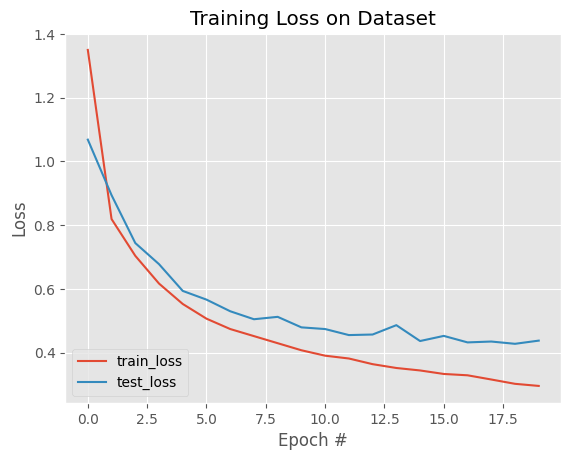

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(loss_list["train_loss"], label="train_loss")
plt.plot(loss_list["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
torch.save(model.state_dict(),MODEL_PATH)

## Evaluation

In [19]:
model_eval=UNet(N_CLASS).cuda()
model_eval.load_state_dict((torch.load(MODEL_PATH)))

<All keys matched successfully>

In [23]:
for (x, y) in testLoader:
    (x, y) = (x, y)

In [25]:
model_eval.eval()
total_ious = []
pixel_accs = []
#jaccard_index=[]
with torch.no_grad():
  for (x, y) in valLoader:
      (x, y) = (x.to(DEVICE), torch.squeeze(y.to(DEVICE)).long())
      pred = model(x)
      pred=torch.argmax(pred,dim=1)
      pred=pred.to(DEVICE)
      for p, t in zip(pred, y):
          total_ious.append(iou(p, t, N_CLASS))
          pixel_accs.append(pixel_acc(p, t))
#jaccards = torch.nanmean(torch.Tensor(jaccard_index))
ious = torch.nanmean(torch.Tensor(total_ious))
pixel_accs_mean = torch.nanmean(torch.Tensor(pixel_accs))
print("IoU: {}, pixel_accs_mean: {}".format(ious, pixel_accs_mean))

IoU: 0.37282752990722656, pixel_accs_mean: 0.8784968256950378


## Prediction

In [9]:
from prediction import make_predictions
N_CLASS=20

In [10]:
model_eval=UNet(N_CLASS)
model_eval.load_state_dict((torch.load(MODEL_PATH)))

<All keys matched successfully>

In [11]:
TEST_PATHS = "/content/drive/MyDrive/Colab Notebooks/city/test/"


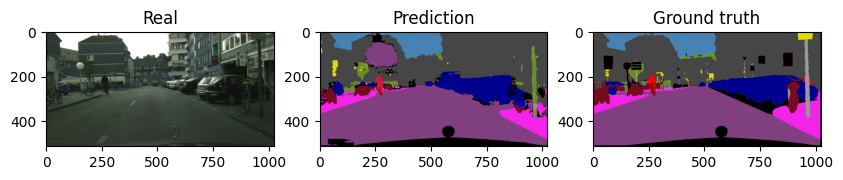

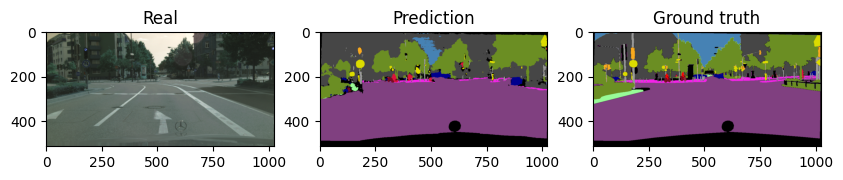

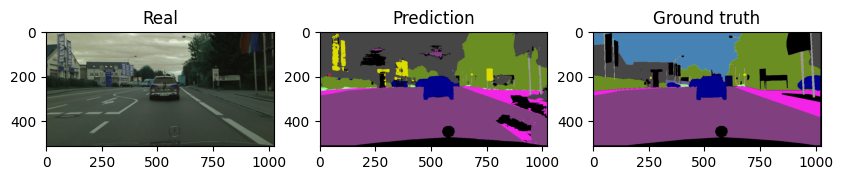

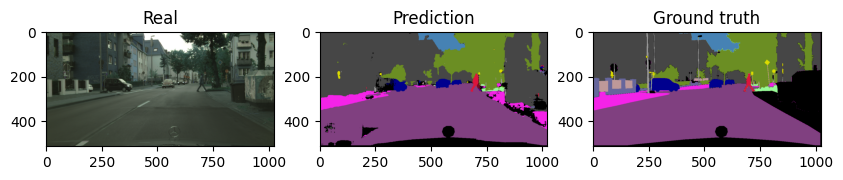

In [12]:
imagePaths = [f for f in os.listdir(TEST_PATHS) if f.startswith("image_")]
imagePaths = np.random.choice(imagePaths, size=4)
test_images=[]
map_images=[]
for image_file in imagePaths:
        # Extract image number from the filename
        image_number = image_file.split("_")[1].split(".")[0]

        # Construct filenames for the image and label map
        image_filename = f"/content/drive/MyDrive/Colab Notebooks/city/test/image_{image_number}.png"
        map_filename = f"/content/drive/MyDrive/Colab Notebooks/city/test/label_{image_number}.png"
        test_images.append(image_filename)
        map_images.append(map_filename)


for i in range(len(test_images)):
	# make predictions and visualize the results
	make_predictions(model_eval, test_images[i],map_images[i])

